## AI Agent Design Patterns with AutoGen v0.4: Embracing a New Architecture

In today’s world of distributed systems and intelligent agents, the ability to communicate asynchronously isn’t just a luxury—it’s a necessity. As systems scale and demands grow, the old paradigm of blocking operations simply can’t keep up. Let’s explore what it means for a system to be asynchronous, why events are the lifeblood of agent communication, and how the actor model sets the stage for building robust, scalable systems.

> If you want to dive deeper into how to build **single-agent** and **multi-agent** architectures in Azure AI, check out the following GitHub repository:
> [**GBB AI Agent Architecture Lab**](https://github.com/pablosalvador10/gbbai-agent-architecture-lab)
> This repository contains hands-on notebooks, examples, and best practices for creating **agentic** systems. Don’t forget to support, share, and give the project a star!

#### The Essence of Asynchronous Systems

Imagine a busy control room where multiple tasks are happening simultaneously. In an asynchronous system, no single task holds up the others. This non-blocking approach means that while one operation waits for a response (say, from a database or a remote API), the system can shift its attention to other tasks. The benefits are clear:

- **Responsiveness:** Applications remain snappy and interactive even during long-running operations.
- **Resource Efficiency:** Idle time is minimized as the processor works on other tasks, making better use of available resources.
- **Simplified Concurrency:** An event loop handles tasks sequentially without the need for heavyweight multi-threading, reducing complexity and potential for errors.

#### Events: The Pulse of Communication

In an event-driven architecture, events are the signals that trigger actions. Think of events as the memos circulating in a bustling office. Each memo informs its recipient that something has occurred—an update, a request, or a change of state.

- **Loose Coupling:**  
  Agents don’t need to know the inner workings of their peers. They simply react to events, making the system highly modular.
- **Scalability:**  
  With the ability to process a flood of events concurrently, the system can easily scale as demand increases.
- **Flexibility:**  
  New agents can be added or removed without disrupting the overall flow of communication.

#### The Actor Model: Building Blocks for Modern Systems

At the heart of many asynchronous systems lies the actor model—a conceptual framework where each “actor” is an independent unit that processes messages, makes decisions, and even spawns new actors. This is what makes the system robust:

- **Encapsulation:**  
  Each actor manages its own state, greatly reducing the risk of conflicts.
- **Independent Concurrency:**  
  By processing messages independently, actors allow the system to scale naturally without complex thread management.
- **Fault Tolerance:**  
  A failure in one actor doesn’t cascade to the entire system. Others continue functioning, ensuring resilience.

For instance, in a multi-agent group chat, each agent—whether it’s a travel advisor, a hotel expert, or a flight specialist—acts as its own actor. They exchange messages, make local decisions, and the system’s orchestrator (like a SelectorGroupChat) ensures that messages flow in a coordinated manner.


#### So does it make sense now why we need AutoGen v0.4: ?

The release of AutoGen v0.4 marks a significant evolution in how agent systems are designed. Here’s what sets it apart:

- **Asynchronous Messaging:**  
  Supports both event-driven and request/response patterns, ensuring smooth and responsive interactions.
- **Modular Architecture:**  
  With plug-and-play components, building long-running, proactive agents has never been easier.
- **Enhanced Observability:**  
  Built-in metrics, message tracing, and integration with OpenTelemetry empower developers with deep insights.
- **Scalability:**  
  The design supports complex, distributed agent networks that can operate seamlessly across organizational boundaries.
- **Community Extensions:**  
  A vibrant ecosystem of built-in and community-driven extensions extends functionality further.
- **Cross-Language Support:**  
  While currently supporting Python and .NET, plans for additional languages are on the horizon.
- **Robust Type Support:**  
  Full type checking at build time ensures improved code quality and reliability.

For a detailed history and in-depth discussion of these updates, check out the full [AutoGen v0.4 release post](https://www.microsoft.com/en-us/research/blog/autogen-v0-4-reimagining-the-foundation-of-agentic-ai-for-scale-extensibility-and-robustness/?msockid=0f2456b6b6d3624d0923433fb70463b6).

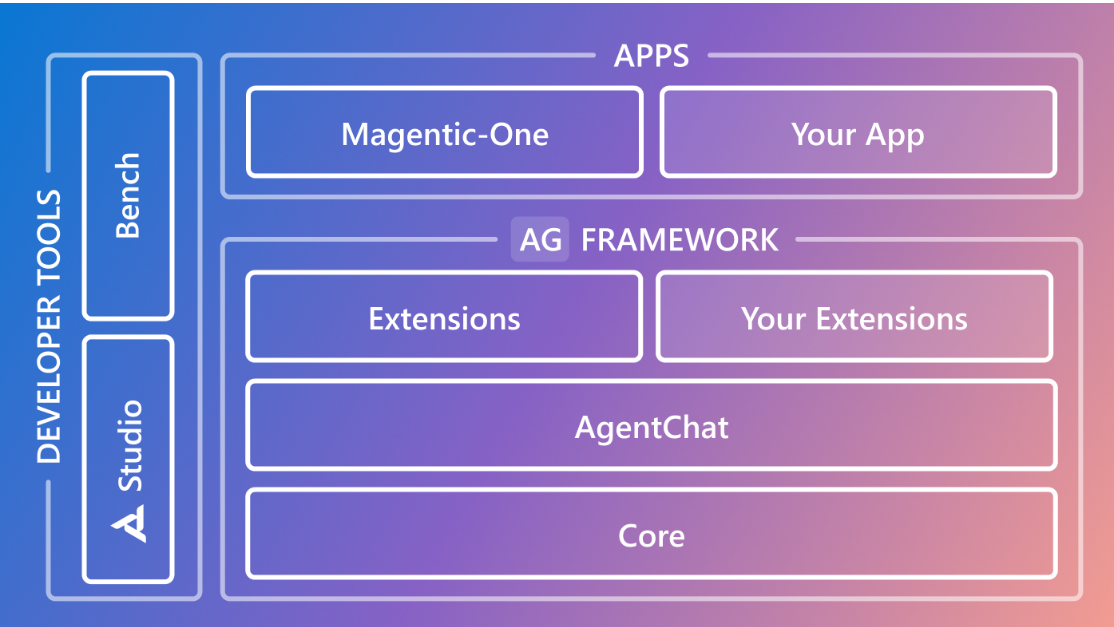

In [1]:
import os
# Define the target directory
target_directory = r"/Users/pablosal/Desktop/azure-ai-engineer-in-five-weeks"  # change your directory to the root folder

# Check if the directory exists
if os.path.exists(target_directory):
    # Change the current working directory
    os.chdir(target_directory)
    print(f"Directory changed to {os.getcwd()}")
else:
    print(f"Directory {target_directory} does not exist.")

from dotenv import load_dotenv
load_dotenv(dotenv_path=".env")

Directory changed to c:\Users\pablosal\Desktop\azure-ai-engineer-in-five-weeks


True

**1. start by installing the required packages. (Make sure your environment has Python 3.8+.)**

In [2]:
# !pip install autogen-agentchat==0.4.5 
# !pip install -U "autogen-ext[openai, diskcache]"

**2. Creating a Model Client**

In v0.4 you now create a model client using one of two methods: either by loading via the generic component configuration or by directly instantiating the client class. For example:

In [3]:
import os
from dotenv import load_dotenv
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

# Load environment variables from a .env file
load_dotenv()

# Create the Azure OpenAI client.
model_client = AzureOpenAIChatCompletionClient(
    model=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_ID"),
    azure_deployment=os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_ID"),
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),  # e.g., "https://your-resource-name.openai.azure.com/"
    api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-06-01"),
    seed=42,
    temperature=0
)

In [4]:
from autogen_core.models import UserMessage
async def test_azure_openai():
    # Prepare a simple message
    messages = [UserMessage(content="What is the capital of France?", source="user")]
    # Send the message to the model and get the response.
    response = await model_client.create(messages)
    print("Response:", response.content)

await test_azure_openai()

Response: The capital of France is **Paris**.


C:\Users\pablosal\AppData\Local\Temp\ipykernel_42108\3473032860.py:6: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect.
  response = await model_client.create(messages)


**3. Adding Caching to the Model Client**

In v0.2 caching was enabled by default using a cache_seed in the config. In v0.4 caching is optional and enabled by wrapping your model client with a cache wrapper.

In [5]:
import os
import asyncio
from diskcache import Cache
from autogen_ext.models.cache import ChatCompletionCache, CHAT_CACHE_VALUE_TYPE
from autogen_ext.cache_store.diskcache import DiskCacheStore
from autogen_core.models import UserMessage

async def caching_example():
    # Provide a persistent directory for the disk cache.
    cache_dir = os.path.join(os.getcwd(), "utils", "diskcache_temp")
    os.makedirs(cache_dir, exist_ok=True)
    
    # Set up a DiskCacheStore using the persistent cache directory.
    cache_store = DiskCacheStore[CHAT_CACHE_VALUE_TYPE](Cache(cache_dir))
    # Wrap the model client with caching.
    cache_client = ChatCompletionCache(model_client, cache_store)
    
    # Send a message and then repeat to see the cached result.
    response1 = await cache_client.create([UserMessage(content="Hello, how are you?", source="user")])
    print("Response 1:", response1)
    
    response2 = await cache_client.create([UserMessage(content="Hello, how are you?", source="user")])
    print("Response 2 (should be cached):", response2)

# Run the caching example.
await caching_example()


Response 1: finish_reason='stop' content="Hello! I'm just a bunch of code, so I don't have feelings, but I'm here and ready to help you with whatever you need. How about you? How are you doing? 😊" usage=RequestUsage(prompt_tokens=14, completion_tokens=38) cached=False logprobs=None thought=None
Response 2 (should be cached): finish_reason='stop' content="Hello! I'm just a bunch of code, so I don't have feelings, but I'm here and ready to help you with whatever you need. How about you? How are you doing? 😊" usage=RequestUsage(prompt_tokens=14, completion_tokens=38) cached=True logprobs=None thought=None


c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_ext\models\cache\_chat_completion_cache.py:137: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect.
  result = await self.client.create(


**4. Creating an Assistant Agent**

In v0.4 you pass in the model_client instance. Also, the method to send messages has changed to an asynchronous method on_messages.

Also in the new Autogen framework, a CancellationToken is a simple object used to signal that an asynchronous operation should be cancelled. When you pass a cancellation token into an agent’s asynchronous method (like on_messages), the agent’s implementation can periodically check the token to see if cancellation has been requested. This is useful in long-running operations or when you want to abort a request based on external conditions (for example, a timeout or user interruption).

In [6]:
import asyncio
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken


async def assistant_example():
    # Create an AssistantAgent with the specified model client.
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,  # Ensure model_client is defined
    )

    # Create a cancellation token.
    cancellation_token = CancellationToken()

    # Define an auxiliary coroutine to cancel the operation after a delay.
    async def cancel_after(delay: float, token: CancellationToken):
        await asyncio.sleep(delay)
        token.cancel()  # Signal that the operation should be cancelled.
        print("Cancellation requested!")

    # Schedule cancellation after 3 seconds (for demonstration purposes).
    asyncio.create_task(cancel_after(3, cancellation_token))

    try:
        # Send a message to the assistant. The cancellation token is passed in.
        response = await assistant.on_messages(
            [TextMessage(content="Hello!", source="user")],
            cancellation_token
        )
        print("Assistant Response:", response.chat_message.content)
    except asyncio.CancelledError:
        print("The operation was cancelled.")

# Run the assistant example.
await assistant_example()


Assistant Response: Hello! 😊 How can I assist you today?


c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_agentchat\agents\_assistant_agent.py:416: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect.
  model_result = await self._model_client.create(


**5. Multi-Modal Agents (Image Support)**

In [7]:
import asyncio
from pathlib import Path
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import CancellationToken, Image

async def multimodal_example():
    
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant. Please Describe images",
        model_client=model_client,
    )
    
    cancellation_token = CancellationToken()
    message = MultiModalMessage(
        content=["Here is an image:", Image.from_file(Path("utils\\images\\azure_logo.png"))],
        source="user",
    )
    response = await assistant.on_messages([message], cancellation_token)
    print("Multi-Modal Assistant Response:", response.chat_message.content)

await multimodal_example()

Cancellation requested!


Multi-Modal Assistant Response: This is the logo for Microsoft Azure, a cloud computing platform and service provided by Microsoft. The logo features a stylized letter "A" with a gradient of blue shades, transitioning from a darker blue on the left to a lighter blue on the right. The design has a modern, folded ribbon-like appearance, giving it a sleek and dynamic look. The background is black, which makes the blue logo stand out prominently.


**6. Using Tools with a Single Assistant Agent**

You simply pass tool functions to the AssistantAgent and enable tool reflection if desired.

In [8]:
import asyncio
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken
from autogen_ext.models.openai import OpenAIChatCompletionClient

# Define a sample tool function.
def get_weather(city: str) -> str:
    return f"The weather in {city} is 72 degrees and sunny."

async def tool_use_example():
    # Initialize the assistant with tool support enabled.
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant who can call tools to help answer questions.",
        model_client=model_client,
        tools=[get_weather],
        reflect_on_tool_use=True,  # Enables reflection on tool usage.
    )
    print("Assistant is ready. Type your message (or 'exit' to quit):")
    
    # Main interaction loop.
    while True:
        user_input = input("User: ")
        if user_input.lower() == "exit":
            print("Exiting...")
            break
        
        # Create a fresh cancellation token for this request.
        cancellation_token = CancellationToken()
        
        try:
            # Send the message to the assistant.
            response = await assistant.on_messages(
                [TextMessage(content=user_input, source="user")],
                cancellation_token
            )
            # Display the assistant's response.
            print("Assistant:", response.chat_message.content)
        except Exception as e:
            print(f"An error occurred: {e}")

# For a Jupyter Notebook, use:
await tool_use_example()


Assistant is ready. Type your message (or 'exit' to quit):
Assistant: Here is an example Python code to query data from a MongoDB database using the `pymongo` library:

```python
from pymongo import MongoClient

# Connect to MongoDB
def connect_to_mongo(uri, database_name):
    try:
        client = MongoClient(uri)
        db = client[database_name]
        print("Connected to MongoDB")
        return db
    except Exception as e:
        print(f"Error connecting to MongoDB: {e}")
        return None

# Query data from a collection
def query_data(db, collection_name, query_filter=None):
    try:
        collection = db[collection_name]
        if query_filter is None:
            query_filter = {}  # Empty filter to fetch all documents
        results = collection.find(query_filter)
        return list(results)
    except Exception as e:
        print(f"Error querying data: {e}")
        return []

# Example usage
if __name__ == "__main__":
    # MongoDB connection URI
    mongo_uri =

**7. Group Chat and Two-Agent Chat (RoundRobin)**

In v0.2, creating a two‑agent chat involved coordinating a user proxy and an assistant agent. In v0.4, you can use the built‑in team (group chat) classes such as RoundRobinGroupChat.

Example 1: Two‑Agent Chat (Human and Assistant)

In this example, a human interacts with an assistant agent. The human types a message, and the assistant generates a response using the provided model client. A new cancellation token is created for each request.

In [9]:
import asyncio
from autogen_agentchat.agents import AssistantAgent, CodeExecutorAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination
from autogen_agentchat.ui import Console
from autogen_ext.code_executors.local import LocalCommandLineCodeExecutor

async def main() -> None:
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant. Write all code in python. Reply only 'TERMINATE' if the task is done.",
        model_client=model_client,
    )

    code_executor = CodeExecutorAgent(
        name="code_executor",
        code_executor=LocalCommandLineCodeExecutor(work_dir="coding"),
    )

    # The termination condition is a combination of text termination and max message termination, either of which will cause the chat to terminate.
    termination = TextMentionTermination("TERMINATE") | MaxMessageTermination(10)

    # The group chat will alternate between the assistant and the code executor.
    group_chat = RoundRobinGroupChat([assistant, code_executor], termination_condition=termination)

    # `run_stream` returns an async generator to stream the intermediate messages.
    stream = group_chat.run_stream(task="Write a python script to print 'Hello, world!'")
    # `Console` is a simple UI to display the stream.
    await Console(stream)

await main()

---------- user ----------
Write a python script to print 'Hello, world!'
---------- assistant ----------
```python
print('Hello, world!')
```


Error processing publish message for code_executor/49f9aae7-1ed3-4d4a-b9df-d8d3f4186c30
Traceback (most recent call last):
  File "c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_core\_single_threaded_agent_runtime.py", line 505, in _on_message
    return await agent.on_message(
  File "c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_core\_base_agent.py", line 113, in on_message
    return await self.on_message_impl(message, ctx)
  File "c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_agentchat\teams\_group_chat\_sequential_routed_agent.py", line 48, in on_message_impl
    return await super().on_message_impl(message, ctx)
  File "c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_core\_routed_agent.py", line 485, in on_message_impl
    return await h(self, message, ctx)
  File "c:\Users\pablosal

Example 2: Group Chat with Three Agents and Human Interaction

In this more advanced example, three agents work together:

- Travel_Advisor: Provides overall travel advice and itineraries.
+ Hotel_Agent: Offers suggestions and details for hotel bookings.
- Flight_Agent: Provides flight options and booking details.
+ Evaluator: Monitors the conversation. If the evaluator determines the conversation is complete (by outputting either "DONE" or "TERMINATE"), the chat will end.

`SelectorGroupChat`:
This group chat component uses a chat completion model to select which agent speaks next based on the conversation history. It takes a list of participants and uses a selector prompt (by default, one that instructs the model to return only the next agent’s name).

`Termination Conditions`: The conversation ends if any agent outputs the keyword (e.g. “DONE”) or if the number of turns exceeds a set limit (here, 12 turns).

`Human Interaction`:
The human supplies the initial task via input, which seeds the conversation. The conversation is then streamed in real time using the built-in Console UI.

How it works ? `A human supplies the initial travel task (for example, "Organize me two days trip to Spain" and the conversation proceeds between the agents`

In [10]:
import asyncio
from autogen_ext.models.openai import OpenAIChatCompletionClient
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import SelectorGroupChat
from autogen_agentchat.conditions import TextMentionTermination, MaxMessageTermination
from autogen_agentchat.ui import Console

async def main():
    # Create three specialized content agents.
    travel_advisor = AssistantAgent(
        name="Travel_Advisor",
        system_message=(
            "You are a travel advisor. Provide suggestions for destinations, itineraries, "
            "and overall travel planning. Respond succinctly."
        ),
        model_client=model_client,
        description="Helps with travel planning."
    )
    
    hotel_agent = AssistantAgent(
        name="Hotel_Agent",
        system_message=(
            "You are a hotel booking expert. Provide detailed information on hotels, "
            "prices, and availability at the travel destination."
        ),
        model_client=model_client,
        description="Assists with hotel booking."
    )
    
    flight_agent = AssistantAgent(
        name="Flight_Agent",
        system_message=(
            "You are a flight booking specialist. Provide flight options, schedules, and pricing "
            "information for travel between cities."
        ),
        model_client=model_client,
        description="Assists with flight booking."
    )
    
    # Create the evaluator agent.
    # This agent monitors the conversation and will output a final summary of the travel plan,
    # including flight arrangements, hotel bookings, and reservations with proper timing coordination.
    # When the plan is complete, it ends its response with 'DONE' or 'TERMINATE'.
    evaluator_agent = AssistantAgent(
        name="Evaluator",
        system_message=(
            "You are an evaluator. Your task is to monitor the conversation and determine if the travel plan "
            "is complete—including flight arrangements, hotel bookings, and reservations with proper timing coordination. "
            "When you determine that the plan is complete, provide a final summary of the travel plan and end your response "
            "with 'DONE' or 'TERMINATE'. If the plan is not complete, continue the discussion without summarizing."
        ),
        model_client=model_client,
        description="Evaluates the conversation for termination conditions and summarizes the final travel plan."
    )
    
    # Define termination conditions:
    # - End the chat if any agent outputs "DONE" or "TERMINATE".
    # - End the chat if more than 12 messages are exchanged.
    termination = TextMentionTermination("DONE") | TextMentionTermination("TERMINATE") | MaxMessageTermination(12)
    
    # Create a SelectorGroupChat to manage the conversation.
    group_chat = SelectorGroupChat(
        participants=[travel_advisor, hotel_agent, flight_agent, evaluator_agent],
        model_client=model_client,
        termination_condition=termination,
        allow_repeated_speaker=False
    )
    
    # Get the initial task from the human.
    task = input("Enter your travel task (e.g., 'Plan a 5-day trip to Paris'): ")
    
    # Start the conversation stream.
    await Console(group_chat.run_stream(task=task))

# Run the group chat example.
await main()


c:\Users\pablosal\AppData\Local\anaconda3\envs\ai-engineering-bootcamp\lib\site-packages\autogen_agentchat\teams\_group_chat\_selector_group_chat.py:139: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect.
  response = await self._model_client.create(messages=select_speaker_messages)


---------- user ----------
Plan a 5-day trip to Paris
---------- Travel_Advisor ----------
### 5-Day Paris Itinerary

**Day 1: Arrival & Iconic Landmarks**  
- Morning: Arrive in Paris, check into your hotel.  
- Afternoon: Visit the Eiffel Tower (pre-book tickets). Stroll through Champ de Mars.  
- Evening: Seine River Cruise for sunset views. Dinner at a nearby bistro.

**Day 2: Historic Paris**  
- Morning: Explore Notre-Dame Cathedral (exterior) and Île de la Cité.  
- Afternoon: Visit Sainte-Chapelle and the Latin Quarter.  
- Evening: Dinner in Saint-Germain-des-Prés. Optional wine bar experience.

**Day 3: Art & Culture**  
- Morning: Tour the Louvre Museum (focus on highlights like the Mona Lisa).  
- Afternoon: Walk through the Tuileries Garden and visit Musée de l’Orangerie.  
- Evening: Explore Montmartre, see Sacré-Cœur, and enjoy dinner at a local café.

**Day 4: Day Trip or Versailles**  
- Morning: Take a half-day trip to the Palace of Versailles (pre-book tickets).  
- 

**8. Saving and Loading Agent State**

In v0.2, you had to manage agent state manually. In v0.4 every agent (or team) has save_state and load_state methods.

In [11]:
import asyncio
import json
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken

async def state_example():
    
    assistant = AssistantAgent(
        name="assistant",
        system_message="You are a helpful assistant.",
        model_client=model_client,
    )
    
    cancellation_token = CancellationToken()
    response = await assistant.on_messages([TextMessage(content="Hello!", source="user")], cancellation_token)
    print("Initial Response:", response.chat_message.content)
    
    # Save the current state (which includes chat history).
    state = await assistant.save_state()
    with open("utils/stateful/assistant_state.json", "w") as f:
        json.dump(state, f)
    
    # Continue the conversation.
    response = await assistant.on_messages([TextMessage(content="Tell me a joke.", source="user")], cancellation_token)
    print("After New Message:", response.chat_message.content)
    
    # Revert state back to before the new message.
    await assistant.load_state(state)
    response = await assistant.on_messages([TextMessage(content="Tell me a joke.", source="user")], cancellation_token)
    print("After Reverting State:", response.chat_message.content)

# Run the state save/load example.
await state_example()


Initial Response: Hello! 😊 How can I assist you today?


FileNotFoundError: [Errno 2] No such file or directory: 'utils/stateful/assistant_state.json'